# Image segmentation with a U-Net-like architecture

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Prepare paths of input images and target segmentation masks

In [9]:
import os

input_dir = "/content/drive/MyDrive/[02] Work/[02] Side Hustle/Body Image Segmentation/data/images"
target_dir = "/content/drive/MyDrive/[02] Work/[02] Side Hustle/Body Image Segmentation/data/masks"
img_size = (128, 128)
num_classes = 1
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 205
/content/drive/MyDrive/[02] Work/[02] Side Hustle/Body Image Segmentation/data/images/001_as_dada1.png | /content/drive/MyDrive/[02] Work/[02] Side Hustle/Body Image Segmentation/data/masks/001_seg_dada1.png
/content/drive/MyDrive/[02] Work/[02] Side Hustle/Body Image Segmentation/data/images/002_as_dada2.png | /content/drive/MyDrive/[02] Work/[02] Side Hustle/Body Image Segmentation/data/masks/002_seg_dada2.png
/content/drive/MyDrive/[02] Work/[02] Side Hustle/Body Image Segmentation/data/images/003_as_dada3.png | /content/drive/MyDrive/[02] Work/[02] Side Hustle/Body Image Segmentation/data/masks/003_seg_dada3.png
/content/drive/MyDrive/[02] Work/[02] Side Hustle/Body Image Segmentation/data/images/004_as_kaki1.png | /content/drive/MyDrive/[02] Work/[02] Side Hustle/Body Image Segmentation/data/masks/004_seg_kaki1.png
/content/drive/MyDrive/[02] Work/[02] Side Hustle/Body Image Segmentation/data/images/005_as_kaki2.png | /content/drive/MyDrive/[02] Work/[02] Si

## What does one input image and corresponding segmentation mask look like?

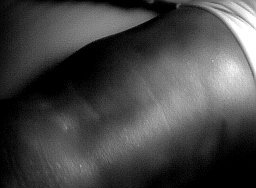

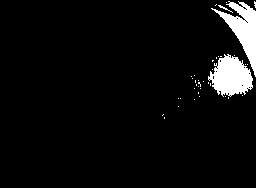

In [10]:
from IPython.display import Image, display
from keras.utils import load_img
from PIL import ImageOps

number = 5

# Display input image #7
display(Image(filename=input_img_paths[number]))


# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[number]))
display(img)

## Prepare dataset to load & vectorize batches of data

In [11]:
import keras
import numpy as np
import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io


def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf.squeeze(target_img, axis=-1)

        # Convert target image to one-hot encoding
        target_img = tf.one_hot(target_img, depth=2, dtype=tf.float32)

        return input_img, target_img


    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)


## Prepare U-Net Xception-style model

In [12]:
from keras import layers

def get_model(img_size):
    inputs = keras.Input(shape=img_size + (3,))

    # Contracting Path (Encoder)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive Path (Decoder)
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = layers.Conv2D(2, (1, 1), activation='sigmoid')(c9)

    model = keras.Model(inputs=[inputs], outputs=[outputs])

    return model

# Build model
model = get_model(img_size)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 128, 128, 16)         448       ['input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 128, 128, 16)         0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 128, 128, 16)         2320      ['dropout_9[0][0]']           
                                                                                            

## Set aside a validation split

In [13]:
import random

# Split our img paths into a training and a validation set
val_samples = 24
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

## Train the model

In [14]:
# Configure the model for training.
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",  # Use binary cross-entropy for binary classification
    metrics=["accuracy"]  # Optional: Add metrics for evaluation
)

callbacks = [
    keras.callbacks.ModelCheckpoint("model_segmentations.keras", save_best_only=True)
]

In [15]:

# Train the model, doing validation at the end of each epoch.
epochs = 50
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/50
6/6 - 64s - loss: 30.9145 - accuracy: 0.9544 - val_loss: 16.2020 - val_accuracy: 0.9681 - 64s/epoch - 11s/step
Epoch 2/50
6/6 - 2s - loss: 19.5004 - accuracy: 0.9531 - val_loss: 12.5591 - val_accuracy: 0.9651 - 2s/epoch - 345ms/step
Epoch 3/50
6/6 - 2s - loss: 14.0484 - accuracy: 0.9337 - val_loss: 9.7198 - val_accuracy: 0.9633 - 2s/epoch - 262ms/step
Epoch 4/50
6/6 - 2s - loss: 10.4924 - accuracy: 0.9216 - val_loss: 7.4612 - val_accuracy: 0.9629 - 2s/epoch - 261ms/step
Epoch 5/50
6/6 - 2s - loss: 8.3623 - accuracy: 0.9104 - val_loss: 5.8276 - val_accuracy: 0.9628 - 2s/epoch - 258ms/step
Epoch 6/50
6/6 - 2s - loss: 7.1541 - accuracy: 0.9090 - val_loss: 5.0692 - val_accuracy: 0.9667 - 2s/epoch - 260ms/step
Epoch 7/50
6/6 - 2s - loss: 6.3075 - accuracy: 0.9228 - val_loss: 4.7120 - val_accuracy: 0.9713 - 2s/epoch - 290ms/step
Epoch 8/50
6/6 - 2s - loss: 5.7659 - accuracy: 0.9345 - val_loss: 4.3569 - val_accuracy: 0.9740 - 2s/epoch - 361ms/step
Epoch 9/50
6/6 - 2s - loss: 5.4183

In [16]:
import joblib
from tensorflow import keras

# Load the best model saved during training
best_model = keras.models.load_model("model_segmentations.keras")

# Export the best model using Joblib
joblib.dump(best_model, "/content/drive/MyDrive/[02] Work/[02] Side Hustle/Body Image Segmentation/models/best_model(256, 256).joblib")

['/content/drive/MyDrive/[02] Work/[02] Side Hustle/Body Image Segmentation/models/best_model(256, 256).joblib']

## Visualize predictions

In [19]:
import joblib
model = joblib.load("/content/drive/MyDrive/[02] Work/[02] Side Hustle/Body Image Segmentation/models/best_model(256, 256).joblib")

1/1 [==============================] - 0s 146ms/step


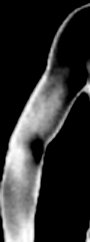

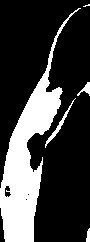

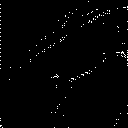

In [22]:
# Generate predictions for all images in the validation set

val_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
val_preds = model.predict(val_dataset)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)

# Display results for validation image #10
i = 4

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)